In [30]:
import numpy as np 
import pandas as pd

import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b3
import torch.nn.functional as F
from torchvision import transforms,models
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data import WeightedRandomSampler
from torchmetrics import F1Score
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

%matplotlib inline
sns.set(rc={'figure.figsize':(13,10)})

In [7]:
DIR = '/kaggle/input/vk-made-sports-image-classification/'

In [8]:
BATCH_SIZE = 32

In [109]:
train_df = pd.read_csv(DIR + 'train.csv')
test_df = pd.read_csv(DIR + 'test.csv')

In [10]:
train_df.shape, test_df.shape

((45373, 2), (19446, 1))

Look at label distribution

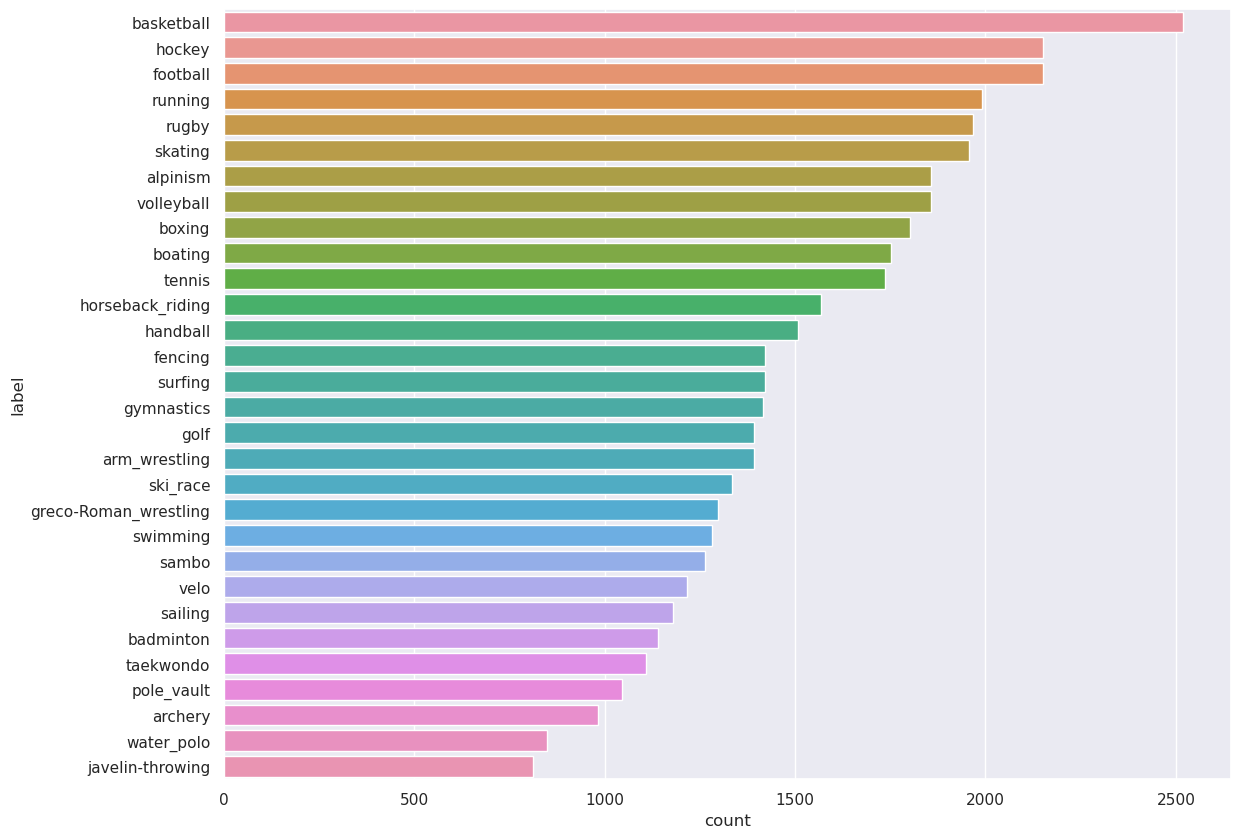

In [11]:
sns.countplot(y=train_df['label'], order = train_df['label'].value_counts().index,);

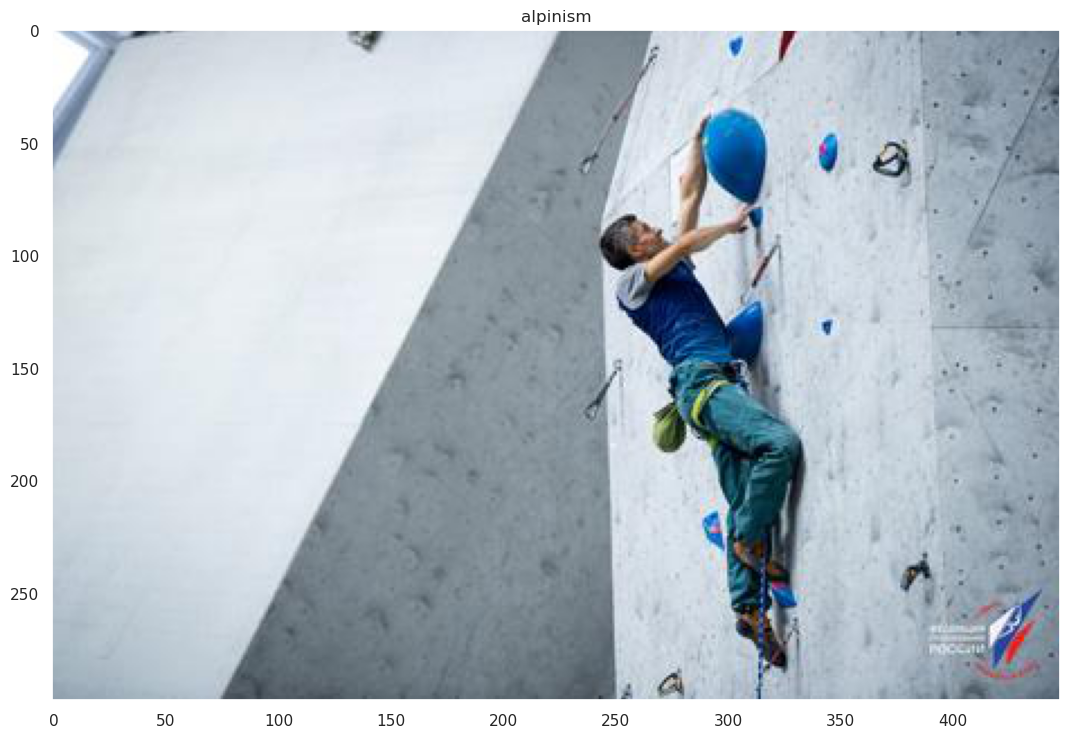

Image size: (448, 298)


In [12]:
# image sample
images = train_df['image_id'].values
ind = np.random.randint(0, len(images))
img = Image.open(DIR + 'train/' + images[ind])
imgplot = plt.imshow(img)
plt.title(train_df['label'][ind])
plt.grid(None)
plt.show()
print(f'Image size: {img.size}')

Images have different sizes. Let's find out the optimal image size for training.

In [13]:
s=[]
for image in images:
    img = Image.open(DIR + 'train/' + image)
    s.append(img.size)

In [14]:
train_df['size'] = s
train_df['width'] = list(zip(*s))[0]
train_df['height'] = list(zip(*s))[1]
train_df['aspect_ratio'] = train_df['width']/train_df['height']

In [15]:
train_df.sample(5)

,image_id,label,size,width,height,aspect_ratio
40591,8793fb64-558b-4911-b0dc-dd9237144fbb.jpeg,taekwondo,"(448, 298)",448,298,1.503356
38934,2ac417f3-e7ce-42df-a9d3-fd3eaa65af93.jpeg,pole_vault,"(448, 283)",448,283,1.583039
7163,7824da8a-ee84-449d-82fc-a3a7db7d3ff4.jpeg,rugby,"(448, 299)",448,299,1.498328
23354,231e51af-d8bc-46ec-8349-67c4e17992cd.jpeg,hockey,"(448, 299)",448,299,1.498328
23059,d9f8044b-fbce-4ef9-8788-838d8825ca53.jpeg,handball,"(448, 217)",448,217,2.064516


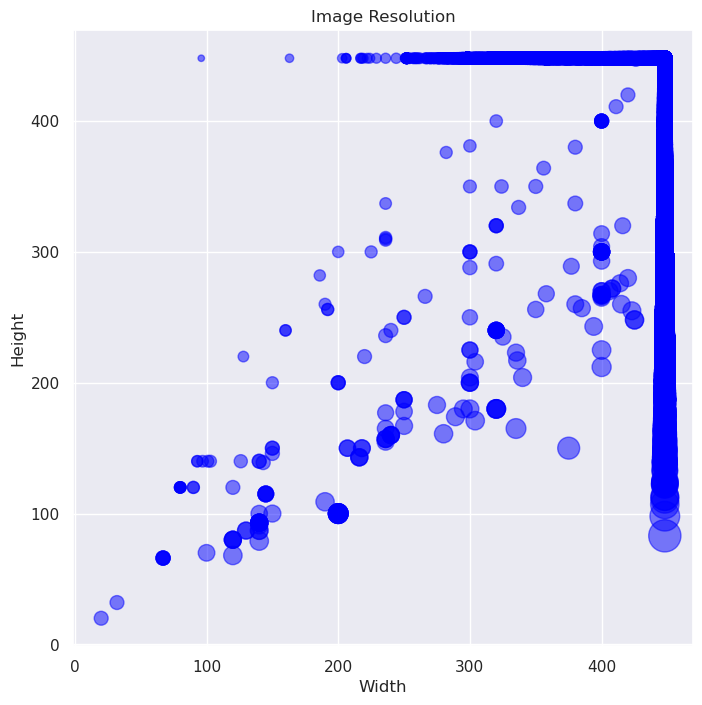

In [16]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(train_df['width'], train_df['height'], color='blue', alpha=0.5, s=train_df["aspect_ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width")
ax.set_ylabel("Height");

In [17]:
# drop images with width or height < 200
train_data = train_df[~(train_df['width'] < 200) | (train_df['height'] < 200)]

In [18]:
label_to_index = {}
index_to_label = {}
for idx, label in enumerate(train_data['label'].unique()):
    label_to_index[label] = idx
    index_to_label[idx] = label

### Split data

In [19]:
train, val = train_test_split(train_data.iloc[:,:2], test_size=0.2, random_state=42, stratify=train_data['label'])
train.shape, val.shape

((36290, 2), (9073, 2))

### Define dataset and dataloader

In [20]:
image_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=320, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.GaussianBlur(5),
        transforms.CenterCrop(size=(300, 300)),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    'valid':
    transforms.Compose([
        transforms.Resize(size=320),
        transforms.CenterCrop(size=(300, 300)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=320),
        transforms.CenterCrop(size=(300, 300)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [21]:
train_dir = DIR + 'train/'
test_dir = DIR + 'test/'

In [22]:
class SportImageDataset(Dataset):
    def __init__(self, images, img_dir, transformer, test_mode=False):
        self.images = images
        self.img_dir = img_dir
        self.transformer = transformer
        self.test_mode = test_mode
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images['image_id'].values[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transformer:
            image = self.transformer(image)
        if self.test_mode:
            return image
        label = label_to_index[self.images.iloc[idx]['label']]
        return image, label

Beacause we have imbalanced classes let's use WeightedRandomSampler
https://pytorch.org/docs/stable/_modules/torch/utils/data/sampler.html#WeightedRandomSampler

In [23]:
class_counts = train['label'].value_counts()
class_weights = 1. / class_counts
sample_weights = [1. / class_counts[i] for i in train['label'].values]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [24]:
trainset = SportImageDataset(train, train_dir, image_transforms['train']) 
validset = SportImageDataset(val, train_dir, image_transforms['valid']) 
testset = SportImageDataset(test_df, test_dir, image_transforms['test'], test_mode=True) 

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, sampler=sampler)
valid_loader = DataLoader(validset, batch_size=BATCH_SIZE)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE)

### Training

In [26]:
NUM_CLASSES = len(train['label'].unique())

In [27]:
class Net(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = efficientnet_b3(pretrained=True)
        # freeze model weights
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.classifier = nn.Sequential(
                      nn.Linear(1536, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, NUM_CLASSES))
        self.lr = 0.0005
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_f1 = F1Score(task="multiclass", num_classes=NUM_CLASSES)
        self.val_f1 = F1Score(task="multiclass", num_classes=NUM_CLASSES)    

    def forward(self, x):
        return self.model(x)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
        
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.train_f1(logits, y)
        self.log('train_f1', self.train_f1, on_epoch=True, prog_bar=True, on_step=False)
        return loss
        
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.loss_fn(logits, y)
        self.log("vall_loss", loss, on_epoch=True, prog_bar=True)
        self.val_f1(logits, y)
        self.log('val_f1', self.val_f1, on_epoch=True, prog_bar=True, on_step=False)

In [28]:
net = Net()

In [31]:
early_stopping = EarlyStopping(monitor="val_f1", mode="max", patience=5)
trainer = pl.Trainer(
    max_epochs=50, 
    accelerator="gpu", 
    callbacks=[early_stopping])

In [32]:
trainer.fit(
    net,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader
)

In [89]:
trainer.save_checkpoint("model_v3.ckpt")

### Make predictions

In [108]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predictions = []
net.to(DEVICE)
net.eval()
with torch.no_grad():
    for tensor in test_loader:
        tensor = tensor.to(DEVICE)
        logits = net(tensor)
        indxes = torch.argmax(logits, dim=1)
        for indx in indxes:
            res = index_to_label[indx.item()]
            predictions.append(res)

### Look at results

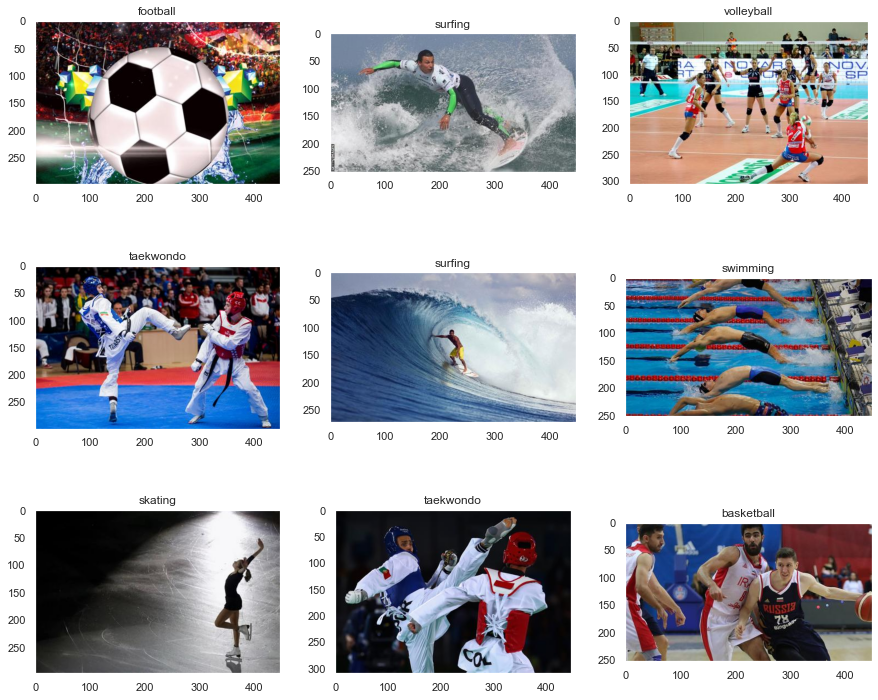

In [57]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
images = test_df['image_id'].values
indxs = np.random.randint(0, len(images), size=9)
for ind, ax in zip(indxs, axs.ravel()):
    img = Image.open(DIR + 'test/' + images[ind])
    imgplot = ax.imshow(img)
    ax.set_title(predictions[ind])
    ax.set_xlabel("")
    ax.grid(False)
plt.show()

In [58]:
test_df['label'] = predictions

In [59]:
test_df.to_csv('submit.csv', index=False)